In [17]:
# Install the FRED API wrapper
!pip install fredapi

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from fredapi import Fred

load_dotenv()

# Authenticate
# Replace the string below with YOUR unique API key from fred.stlouisfed.org
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key)

In [19]:
# 1. Fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a DataFrame
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage data starts later than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031
2025-12-01         31.76  326.030


In [20]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]
    
    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today
    
    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-07-01         31.35  322.132  31.729355
2025-08-01         31.45  323.364  31.709292
2025-09-01         31.52  324.368  31.681502
2025-11-01         31.73  325.031  31.827524
2025-12-01         31.76  326.030  31.760000


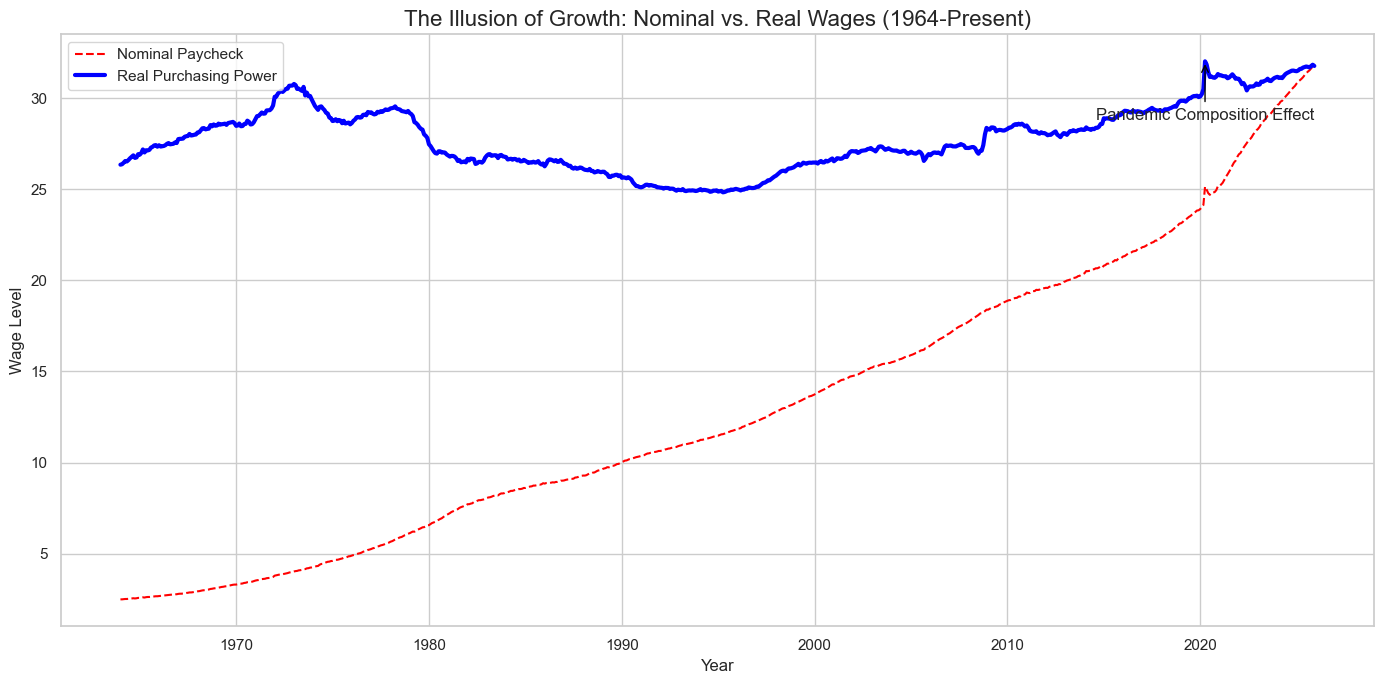

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create figure
plt.figure(figsize=(14, 7))

# Plot Nominal and Real Wages
plt.plot(
    df.index,
    df["Nominal_Wage"],
    linestyle="--",
    color="red",
    label="Nominal Paycheck"
)

plt.plot(
    df.index,
    df["Real_Wage"],
    linewidth=3,
    color="blue",
    label="Real Purchasing Power"
)

# Title and labels
plt.title("The Illusion of Growth: Nominal vs. Real Wages (1964-Present)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Wage Level")

# --- Annotation for 2020 spike in Real Wages ---
# Isolate 2020 data and find the spike
real_2020 = df.loc["2020", "Real_Wage"]
spike_date = real_2020.idxmax()
spike_value = real_2020.max()

plt.annotate(
    "Pandemic Composition Effect",
    xy=(spike_date, spike_value),
    xytext=(spike_date, spike_value * 0.9),
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize=12,
    ha="center"
)

# Legend
plt.legend()

# Tight layout for clean spacing
plt.tight_layout()

plt.show()


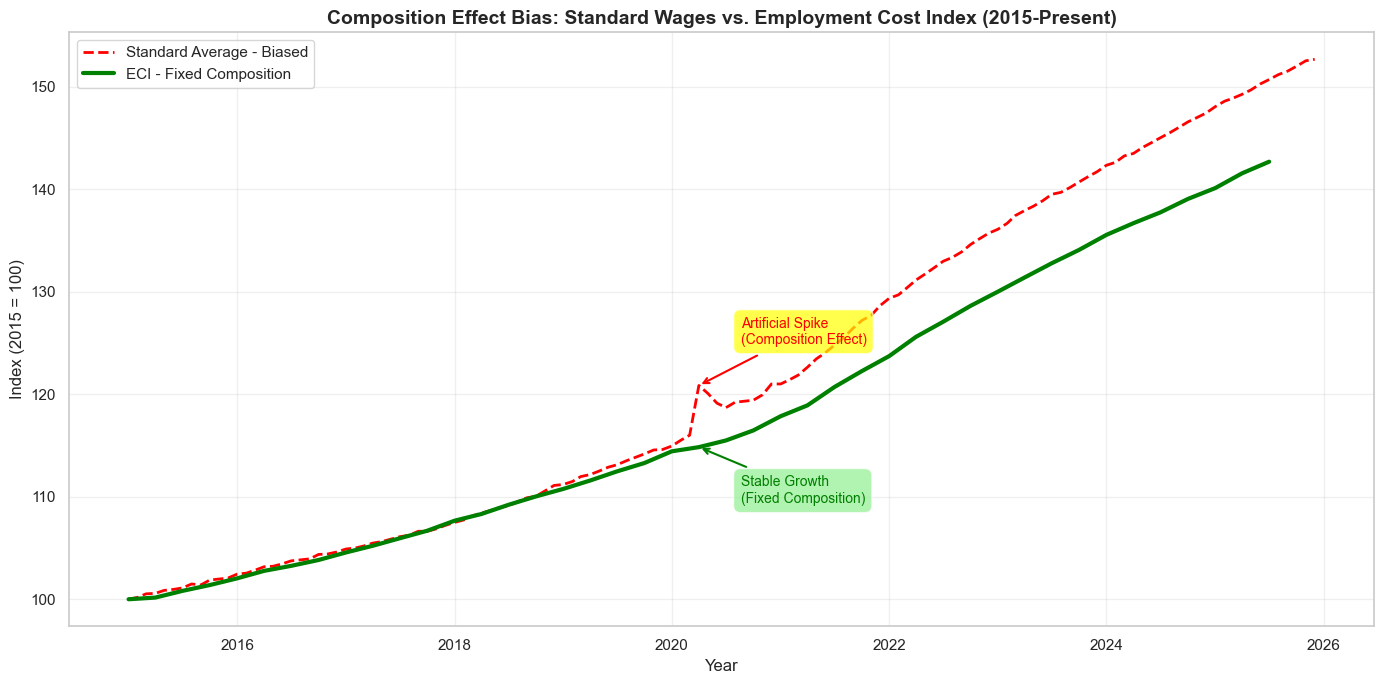


=== Summary Statistics ===

Standard Wages (2015-Present):
  Starting Value: 100.00
  Ending Value: 152.69
  Total Growth: 52.69%

Employment Cost Index (2015-Present):
  Starting Value: 100.00
  Ending Value: 142.70
  Total Growth: 42.70%


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Fetch the Employment Cost Index using the existing 'fred' object
eci = fred.get_series('ECIWAG')

# 2. Filter both series to show only dates from 2015-01-01 onwards
wages_filtered = wages[wages.index >= '2015-01-01']
eci_filtered = eci[eci.index >= '2015-01-01']

# 3. Rebase both series to 100 (divide by the first value * 100)
wages_rebased = (wages_filtered / wages_filtered.iloc[0]) * 100
eci_rebased = (eci_filtered / eci_filtered.iloc[0]) * 100

# 4. Plot both series on the same chart
plt.figure(figsize=(14, 7))

# Plot wages as a red dashed line
plt.plot(wages_rebased.index, wages_rebased, 
         color='red', 
         linestyle='--', 
         linewidth=2, 
         label='Standard Average - Biased')

# Plot ECIWAG as a green thick line
plt.plot(eci_rebased.index, eci_rebased, 
         color='green', 
         linestyle='-', 
         linewidth=3, 
         label='ECI - Fixed Composition')

# Add title and labels
plt.title('Composition Effect Bias: Standard Wages vs. Employment Cost Index (2015-Present)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Index (2015 = 100)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)

# 5. Annotate the 2020 divergence
# Find the 2020 data points
wages_2020 = wages_rebased[wages_rebased.index.year == 2020]
eci_2020 = eci_rebased[eci_rebased.index.year == 2020]

if len(wages_2020) > 0 and len(eci_2020) > 0:
    # Get a mid-2020 point for annotation (e.g., around April-May when divergence was strongest)
    mid_2020_date = pd.Timestamp('2020-04-01')
    
    # Find closest dates to mid-2020 in both series
    wages_2020_val = wages_rebased.iloc[abs(wages_rebased.index - mid_2020_date).argsort()[0]]
    wages_2020_date = wages_rebased.index[abs(wages_rebased.index - mid_2020_date).argsort()[0]]
    
    eci_2020_val = eci_rebased.iloc[abs(eci_rebased.index - mid_2020_date).argsort()[0]]
    eci_2020_date = eci_rebased.index[abs(eci_rebased.index - mid_2020_date).argsort()[0]]
    
    # Annotate the artificial spike in standard wages
    plt.annotate('Artificial Spike\n(Composition Effect)', 
                 xy=(wages_2020_date, wages_2020_val),
                 xytext=(30, 30),
                 textcoords='offset points',
                 fontsize=10,
                 color='red',
                 arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
    
    # Annotate the stable growth in ECI
    plt.annotate('Stable Growth\n(Fixed Composition)', 
                 xy=(eci_2020_date, eci_2020_val),
                 xytext=(30, -40),
                 textcoords='offset points',
                 fontsize=10,
                 color='green',
                 arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("\n=== Summary Statistics ===")
print(f"\nStandard Wages (2015-Present):")
print(f"  Starting Value: {wages_rebased.iloc[0]:.2f}")
print(f"  Ending Value: {wages_rebased.iloc[-1]:.2f}")
print(f"  Total Growth: {wages_rebased.iloc[-1] - 100:.2f}%")

print(f"\nEmployment Cost Index (2015-Present):")
print(f"  Starting Value: {eci_rebased.iloc[0]:.2f}")
print(f"  Ending Value: {eci_rebased.iloc[-1]:.2f}")
print(f"  Total Growth: {eci_rebased.iloc[-1] - 100:.2f}%")

# Optionally save the figure
# plt.savefig('composition_bias_comparison.png', dpi=300, bbox_inches='tight')